![tutorialpromo](images/tutorial_banner.PNG)


<b>

This tutorial is a modification of tutorial 1 and tutorial 5 from our ["Modeling Solar 101"](https://github.com/PVSC-Python-Tutorials/PVSC50) Pvlib trainings, which have been offered at PVSC, PVMC, PyData Global, Hands On PV Workshop, and other events. It is a great way for students and solar enthusiasts to learn solar basics AND python coding. You can find our latest tutorial here: [https://github.com/PVSC-Python-Tutorials/PVSC50](https://github.com/PVSC-Python-Tutorials/PVSC50) 
</b>

# Tutorial 1 & 5 - NSRDB Weather Data to Array Power with PVLib



![Overview](images/tutorial_overview.PNG)

## Steps:
- [Weather data in PV performance models](#Weather-Data-&-PV)
- Looking at a sample weather data file
- Where to get weather data from? 
- Weather data to API

## PV Concepts:
- TMY
- GHI, DNI, DHI
- DryBulb, Wspd
- Irradiance vs. Insolation

## Python Concepts:
- Exploring a Pandas dataframe (`df`): `len()`, `df.head()`, `df.keys()`
- [pvlib input-output tools](https://pvlib-python.readthedocs.io/en/stable/api.html#io-tools)
- Ploting a Pandas dataframe (`df`): `df.plot()`
- Aggregating data in a dataframe (`df`): [`df.resample(freq).sum()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html)
- Pandas [`DateOffsets`](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) - shortcuts to set the frequency when resampling
- Getting NREL irradiance data from the web based API using pvlib

## Weather Data & PV 

Weather and irradiance data are used as input to PV performance models.  


![SRRL](images/tutorial_1_SRRL.PNG)



These data are directly measured, derived from measured data, or simulated using a stochastic model.






## Typical Meteorological Year

TMY datasets are intended to represent the weather for a typical year at a given location. 

TMY datasets provide hourly **solar irradiance**, **air temperature**, **wind speed**, and other weather measurements for a hypothetical year that represents more or less a "median year" for solar resource.  


![TMY3 screenshot](images/tutorial_1_tmy3_example.PNG)

TMY datasets are created by selecting individual months out of an extended period of weather measurememts (say, 20 years of data) to construct a single year's worth of data. There are several methods for selecting which months to include, but the general idea is to calculate monthly summary statistics and take the month that lies in the middle of the distribution.  For example, no two Januaries will be exactly the same, so summing the total solar irradiance for each January will give a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution), and the month that falls closest to the [median](https://en.wikipedia.org/wiki/Median) is chosen as the representative month. The same process is followed for February, March, and so on, and all twelve representative months are stitched together into a year-long dataset.  

The oldest TMYs were calculated using data from the nearest weather station (airports and such). Today, it's common to use TMYs calculated using simulated weather data from satellite imagery because of the improved spatial resolution.

To get a better feel for TMY data, we'll first explore an example TMY dataset that is bundled with pvlib.

## First Step: Import Libraries

In Python, some functions are builtin like `print()` but others must be imported before they can be used. For this notebook we're going to import three packages:
* [pvlib](https://pvlib-python.readthedocs.io/en/stable/) - library for simulating performance of photovoltaic energy systems. 
* [pandas](https://pandas.pydata.org/) - analysis tool for timeseries and tabular data
* [matplotlib](https://matplotlib.org/) - data visualization for Python

Some Python modules are part of the [standard library](https://docs.python.org/3/library/index.html), but are not imported with builtins. We'll use the `pathlib` module which is useful for accessing files and folders.

In [1]:
# if running on google colab, uncomment the next line and execute this cell to install the dependencies and prevent "ModuleNotFoundError" in later cells:
!pip install -r https://raw.githubusercontent.com/PVSC-Python-Tutorials/PVSC50/main/requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os  # for getting environment variables
import pathlib  # for finding the example dataset
import pvlib
import pandas as pd  # for data wrangling
import matplotlib.pyplot as plt  # for visualization

Query which version you are using of pvlib:

In [3]:
print(pvlib.__version__)

0.9.5


## Irradiance 

Irradiance is an instantaneous measurement of solar power over some area.  For practical purposes of measurement and interpretation, irradiance is expressed and separated into different components.

![overview irradiance](images/tutorial_1_DNIDHIGHI.PNG)

The units of irradiance are watts per square meter.  

## Wind

Wind speed is measured with an anemometer.  The most common type is a the cup-type anemometer, shown on the right side of the picture below.  The number of rotations per time interval is used to calculate the wind speed.  The vane on the left is used to measure the direction of the wind.  Wind direction is reported as the direction from which the wind is blowing.

<img src="https://pvpmc.sandia.gov/app/uploads/sites/243/2022/11/anemometer.jpg"></img>

## Air temperature 

Also known as dry-bulb temperature, is the temperature of the ambient air when the measurement device is shielded from radiation and moisture. The most common method of air temperature measurement uses a resistive temperature device (RTD) or thermocouple within a radiation shield. The shield blocks sunlight from reaching the sensor (avoiding radiative heating), yet allows natural air flow around the sensor. More accurate temperature measurement devices utilize a shield which forces air across the sensor.

Air temperature is typically measured on the Celsius scale.

Air temperature plays a large role in PV system performance as PV modules and inverters are cooled convectively by the surrounding air.

<img src="https://www.sandia.gov/app/uploads/sites/243/2022/11/AmbTemp-768x1024-1.jpg" width="400" height="400"> </img>


GHI, DHI, and DNI are the three "basic" ways of measuring irradiance, although each of them is measured in units of power per area (watts per square meter):

- GHI: Global Horizontal Irradiance; the total sunlight intensity falling on a horizontal plane
- DHI: Diffuse Horizontal Irradiance; the subset of sunlight falling on a horizontal plane that isn't coming directly from the sun (e.g., the light that makes the sky blue)
- DNI: Direct Normal Irradiance; the subset of sunlight coming directly from the sun

![Overview](images/t1_GHI.PNG)



![Overview](images/t1_DHI.PNG)



![Overview](images/t1_DNI.PNG)


## Where to get _Free_ Solar Irradiance Data?

There are many different sources of solar irradiance data. For your projects, these are some of the most common:

- [NSRDB](https://maps.nrel.gov/nsrdb-viewer/) - National Solar Radiation Database. You can access data through the website for many locations accross the world, or you can use their [web API](https://developer.nrel.gov/docs/solar/nsrdb/) to download data programmatically. An "API" is an ["application programming interface"](https://en.wikipedia.org/wiki/API), and a "web API" is a programming interface that allows you to write code to interact with web services like the NSRDB.

- [EPW](https://www.energy.gov/eere/buildings/downloads/energyplus-0) - Energy Plus Weather data is available for many locations accross the world. It's in its own format file ('EPW') so you can't open it easily in a spreadsheet program like Excel, but you can use [`pvlib.iotools.read_epw()`](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.iotools.read_epw.html) to get it into a dataframe and use it.

- [PVGIS](https://re.jrc.ec.europa.eu/pvg_tools/en/) - Free global weather data provided by the European Union and derived from many govermental agencies including the NSRDB. PVGIS also provides a web API. You can get PVGIS TMY data using [`pvlib.iotools.get_pvgis_tmy()`](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.iotools.get_pvgis_tmy.html).

- Perhaps another useful link: https://sam.nrel.gov/weather-data.html

## Where else can you get historical irradiance data?

There are several commercial providers of solar irradiance data. Data is available at different spatial and time resolutions. Each provider offers data under subscription that will provide access to irradiance (and other weather variables) via API to leverage in python.

* [SolarAnywhere](https://www.solaranywhere.com/)
* [SolarGIS](https://solargis.com/)
* [Vaisala](https://www.vaisala.com/en)
* [Meteonorm](https://meteonorm.com/en/)
* [DNV Solar Resource Compass](https://src.dnv.com/)


![NSRDB Example](images/tutorial_1_NSRDB_example.PNG)


## NREL API Key
At the [NREL Developer Network](https://developer.nrel.gov/), there are [APIs](https://en.wikipedia.org/wiki/API) to a lot of valuable [solar resources](https://developer.nrel.gov/docs/solar/) like [weather data from the NSRDB](https://developer.nrel.gov/docs/solar/nsrdb/), [operational data from PVDAQ](https://developer.nrel.gov/docs/solar/pvdaq-v3/), or indicative calculations using [PVWatts](https://developer.nrel.gov/docs/solar/pvwatts/). In order to use these resources from NREL, you need to [register for a free API key](https://developer.nrel.gov/signup/). You can test out the APIs using the `DEMO_KEY` but it has limited bandwidth compared to the [usage limit for registered users](https://developer.nrel.gov/docs/rate-limits/). NREL has some [API usage instructions](https://developer.nrel.gov/docs/api-key/), but pvlib has a few builtin functions, like [`pvlib.iotools.get_psm3()`](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.iotools.get_psm3.html), that wrap the NREL API, and call them for you to make it much easier to use. Skip ahead to the next section to learn more. But before you do...


<div class="alert alert-block alert-info"> <b>Please pause now to visit <a href="https://developer.nrel.gov/signup/"> https://developer.nrel.gov/signup/ </a> and get an API key</b> </div>

### Application Programming Interface (API)
What exactly is an API? Nowadays, the phrase is used interchangeably with a "web API" but in general an API is just a recipe for how to interface with a application programmatically, _IE_: in code. An API could be as simple as a function signature or its published documentation, _EG_: the API for the `solarposition` function is you give it an ISO8601 formatted date with a timezone, the latitude, longitude, and elevation as numbers, and it returns the zenith and azimuth as numbers.

A web API is the same, except the application is a web service, that you access at its URL using web methods. We won't go into too much more detail here, but the most common web method is `GET` which is pretty self explanatory. Look over the [NREL web usage instructions](https://developer.nrel.gov/docs/api-key/) for some examples, but interacting with a web API can be as easy as entering a URL into a browser. Try the URL below to _get_ the PVWatts energy output for a fixed tilt site in [Broomfield, CO](https://goo.gl/maps/awkEcNGzSur9Has18).

https://developer.nrel.gov/api/pvwatts/v6.json?api_key=DEMO_KEY&lat=40&lon=-105&system_capacity=4&azimuth=180&tilt=40&array_type=1&module_type=1&losses=10

In addition to just using your browser, you can also access web APIs programmatically. The most popular Python package to interact with web APIs is [requests](https://docs.python-requests.org/en/master/). There's also free open source command-line tools like [cURL](https://curl.se/) and [HTTPie](https://httpie.io/), and a popular nagware/freemium GUI application called [Postman](https://www.postman.com/).

**If you have an NREL API key please enter it in the next cell.**

In [4]:
NREL_API_KEY = None  # <-- please set your NREL API key here

# note you must use "quotes" around your key, for example:
# NREL_API_KEY = 'DEMO_KEY'  # single or double both work fine

# during the live tutorial, we've stored a dedicated key on our server
if NREL_API_KEY is None:
    try:
        NREL_API_KEY = os.environ['NREL_API_KEY']  # get dedicated key for tutorial from servier
    except KeyError:
        NREL_API_KEY = 'DEMO_KEY'  # OK for this demo, but better to get your own key

## Fetching TMYs from the NSRDB

The example TMY dataset used here is from an airport in North Carolina, but what if we wanted to model a PV system somewhere else? The NSRDB, one of many sources of weather data intended for PV modeling, is free and easy to access using pvlib. As an example, we'll fetch a TMY dataset for San Juan, Puerto Rico at coordinates [(18.4671, -66.1185)](https://goo.gl/maps/ZuYuKFxSpJ1z9HXX8). We use [`pvlib.iotools.get_psm3()`](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.iotools.get_psm3.html) which returns a Python dictionary of metadata and a Pandas dataframe of the timeseries weather data.

In [5]:
df_tmy, metadata = pvlib.iotools.get_psm3(
    latitude=39.7407, longitude=-105.1686,
    api_key=NREL_API_KEY,
    email='silvana.ovaitt@nrel.gov',  # <-- any email works here fine
    names='tmy')
metadata



C:\Users\sayala\AppData\Roaming\Python\Python311\site-packages\pvlib\iotools\psm3.py:359: pvlibDeprecationWarning: PSM3 variable names will be renamed to pvlib conventions by default starting in pvlib 0.11.0. Specify map_variables=True to enable that behavior now, or specify map_variables=False to hide this warning.
  warnings.warn(


{'Source': 'NSRDB',
 'Location ID': '145809',
 'City': '-',
 'State': '-',
 'Country': '-',
 'Latitude': 39.73,
 'Longitude': -105.18,
 'Time Zone': -7,
 'Elevation': 1820,
 'Local Time Zone': -7,
 'Dew Point Units': 'c',
 'DHI Units': 'w/m2',
 'DNI Units': 'w/m2',
 'GHI Units': 'w/m2',
 'Temperature Units': 'c',
 'Pressure Units': 'mbar',
 'Wind Direction Units': 'Degrees',
 'Wind Speed Units': 'm/s',
 'Surface Albedo Units': 'N/A',
 'Version': '3.2.0'}

In [6]:
df_tmy.head()

,Year,Month,Day,Hour,Minute,Temperature,Dew Point,DHI,DNI,GHI,Surface Albedo,Pressure,Wind Direction,Wind Speed
2011-01-01 00:30:00-07:00,2011,1,1,0,30,-15.0,-26.0,0.0,0.0,0.0,0.87,790.0,277.0,3.7
2011-01-01 01:30:00-07:00,2011,1,1,1,30,-15.0,-26.0,0.0,0.0,0.0,0.87,800.0,275.0,3.7
2011-01-01 02:30:00-07:00,2011,1,1,2,30,-15.0,-26.0,0.0,0.0,0.0,0.87,800.0,273.0,3.7
2011-01-01 03:30:00-07:00,2011,1,1,3,30,-15.0,-25.0,0.0,0.0,0.0,0.87,800.0,272.0,3.7
2011-01-01 04:30:00-07:00,2011,1,1,4,30,-15.0,-25.0,0.0,0.0,0.0,0.87,800.0,271.0,3.7


In [7]:
df_tmy.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature', 'Dew Point',
       'DHI', 'DNI', 'GHI', 'Surface Albedo', 'Pressure', 'Wind Direction',
       'Wind Speed'],
      dtype='object')

TMY datasets from the PSM3 service of the NSRDB are timestamped using the real year that the measurements came from. The [`pvlib.iotools.read_tmy3()`](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.iotools.read_tmy3.html) function had a `coerce_year` argument to force everything to align to a single dummy year, but [`pvlib.iotools.get_psm3()`](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.iotools.get_psm3.html) doesn't have that feature. For convenience let's standardize the data to 1990 and then compare monthly GHI to the North Carolina location:

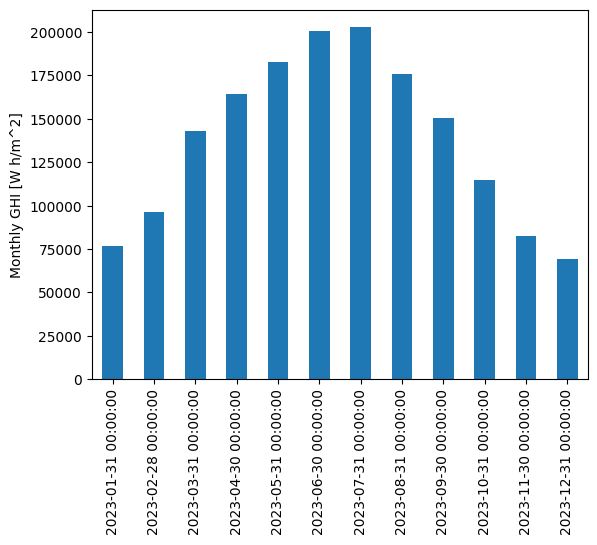

In [8]:
df_tmy['Year'] = 2023
df_tmy.index = pd.to_datetime(df_tmy[['Year', 'Month', 'Day', 'Hour', 'Minute']])

monthly = df_tmy['GHI'].resample('M').sum()
monthly.plot.bar()
plt.ylabel('Monthly GHI [W h/m^2]');

In [9]:
location = pvlib.location.Location(latitude=metadata['Latitude'],
                                   longitude=metadata['Longitude'])

solar_position = location.get_solarposition(times = df_tmy.index)

tracker_data = pvlib.tracking.singleaxis(solar_position['apparent_zenith'],
                                         solar_position['azimuth'],
                                         axis_azimuth=180,
                                         )
tilt = tracker_data['surface_tilt'].fillna(0)
azimuth = tracker_data['surface_azimuth'].fillna(0)

df_poa_tracker = pvlib.irradiance.get_total_irradiance(surface_tilt=tilt,
                                                       surface_azimuth=azimuth,
                                                       dni=df_tmy['DNI'],
                                                       ghi=df_tmy['GHI'],
                                                       dhi=df_tmy['DHI'],
                                                       solar_zenith=solar_position['apparent_zenith'],
                                                       solar_azimuth=solar_position['azimuth'])
tracker_poa = df_poa_tracker['poa_global']

parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
cell_temperature = pvlib.temperature.sapm_cell(tracker_poa,
                                               df_tmy['Temperature'],
                                               df_tmy['Wind Speed'],
                                               **parameters)

In [10]:
gamma_pdc = -0.004  # divide by 100 to go from %/°C to 1/°C
nameplate = 1e3

array_power = pvlib.pvsystem.pvwatts_dc(tracker_poa, cell_temperature, nameplate, gamma_pdc)

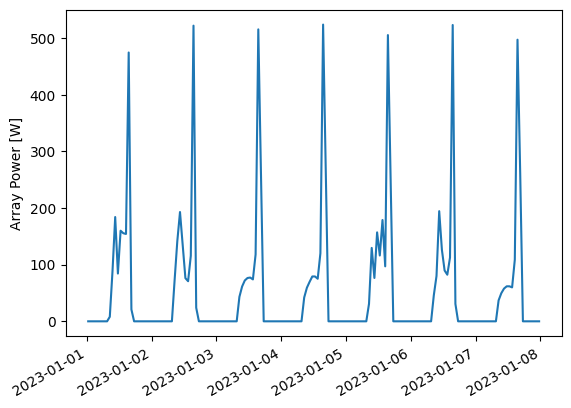

In [11]:
array_power.head(24*7).plot()
plt.ylabel('Array Power [W]');

Let's take a look at the array's response to irradiance and temperature:

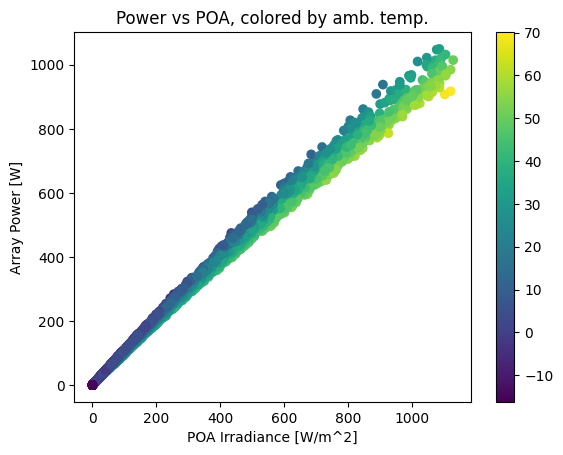

In [12]:
plt.scatter(tracker_poa, array_power, c=cell_temperature)
plt.colorbar()
plt.ylabel('Array Power [W]')
plt.xlabel('POA Irradiance [W/m^2]')
plt.title('Power vs POA, colored by amb. temp.');

This plot shows a strong, near-linear trend of power with POA irradiance.  However, it also shows a performance change with temperature -- as ambient temperature increases, array output drops.  The gradient is smoother if we color by cell temperature:

We can also compare with a hypothetical module with a smaller temperature coefficient, which shows a correspondingly smaller temperature effect:

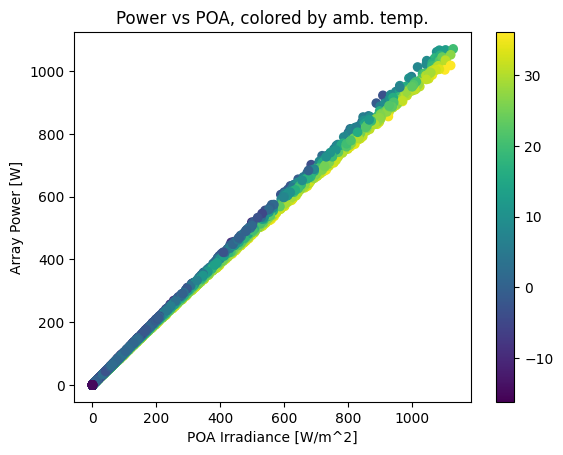

In [13]:
array_power_low_tempco = pvlib.pvsystem.pvwatts_dc(tracker_poa, cell_temperature, nameplate, -0.002)
plt.scatter(tracker_poa, array_power_low_tempco, c=df_tmy['Temperature'])
plt.colorbar()
plt.ylabel('Array Power [W]')
plt.xlabel('POA Irradiance [W/m^2]')
plt.title('Power vs POA, colored by amb. temp.');

[![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)](http://creativecommons.org/licenses/by/4.0/)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).